In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Bibliothèques chargées !")

# Charger les données nettoyées
events = pd.read_csv('../data/processed/events_clean.csv')
events['datetime'] = pd.to_datetime(events['datetime'])
events['date'] = pd.to_datetime(events['date'])

print(f"\n📊 Données chargées : {len(events):,} événements")
print(f"📅 Période : {events['datetime'].min()} → {events['datetime'].max()}")

✅ Bibliothèques chargées !



📊 Données chargées : 2,756,101 événements
📅 Période : 2015-05-03 03:00:04.384000 → 2015-09-18 02:59:47.788000


📌 SEGMENTATION DES UTILISATEURS



📊 Statistiques par utilisateur :
       total_events  unique_products         views     addtocart     purchases
count  1.407580e+06     1.407580e+06  1.407580e+06  1.407580e+06  1.407580e+06
mean   1.958042e+00     1.524019e+00  1.892832e+00  4.925617e-02  1.595433e-02
std    1.258049e+01     7.143724e+00  1.099370e+01  1.165057e+00  8.260909e-01
min    1.000000e+00     1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    1.000000e+00     1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
50%    1.000000e+00     1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
75%    2.000000e+00     1.000000e+00  2.000000e+00  0.000000e+00  0.000000e+00
max    7.757000e+03     3.814000e+03  6.479000e+03  7.190000e+02  5.590000e+02

🎯 Répartition des segments :


segment
Visiteur simple      1368715
Panier sans achat      27146
Acheteur               11719
Name: count, dtype: int64


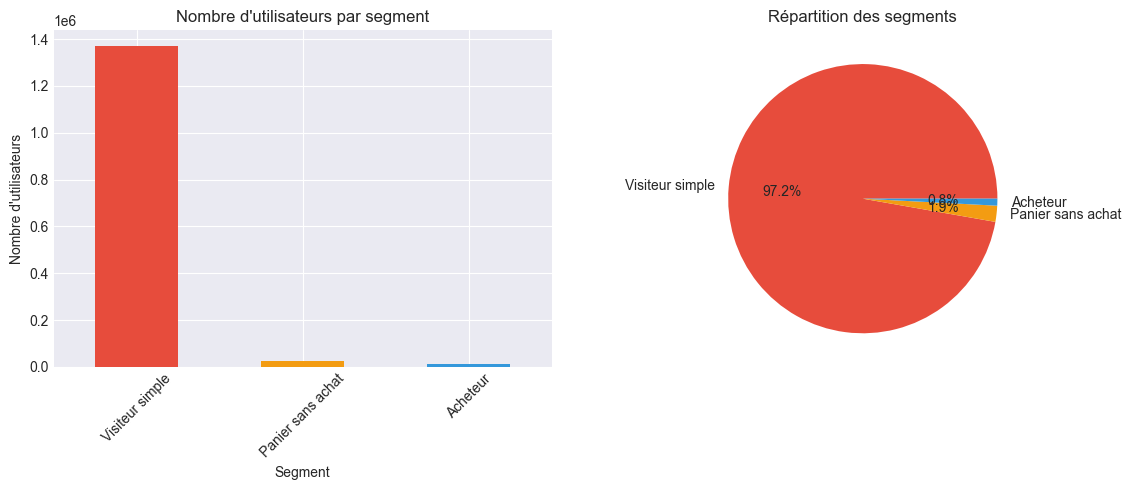


✅ Graphique sauvegardé !


In [2]:
# Segmentation des utilisateurs par comportement
print("=" * 60)
print("📌 SEGMENTATION DES UTILISATEURS")
print("=" * 60)

# Comportement par utilisateur
user_behavior = events.groupby('visitorid').agg({
    'event': 'count',  # Nombre total d'événements
    'itemid': 'nunique'  # Nombre de produits différents consultés
}).rename(columns={'event': 'total_events', 'itemid': 'unique_products'})

# Compter les actions spécifiques par utilisateur
user_views = events[events['event'] == 'view'].groupby('visitorid').size()
user_addtocart = events[events['event'] == 'addtocart'].groupby('visitorid').size()
user_purchases = events[events['event'] == 'transaction'].groupby('visitorid').size()

user_behavior['views'] = user_views
user_behavior['addtocart'] = user_addtocart.fillna(0)
user_behavior['purchases'] = user_purchases.fillna(0)

# Remplir les NaN
user_behavior = user_behavior.fillna(0)

# Créer des segments
def categorize_user(row):
    if row['purchases'] > 0:
        return 'Acheteur'
    elif row['addtocart'] > 0:
        return 'Panier sans achat'
    else:
        return 'Visiteur simple'

user_behavior['segment'] = user_behavior.apply(categorize_user, axis=1)

print("\n📊 Statistiques par utilisateur :")
print(user_behavior.describe())

print("\n🎯 Répartition des segments :")
segment_counts = user_behavior['segment'].value_counts()
print(segment_counts)

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
segment_counts.plot(kind='bar', color=['#e74c3c', '#f39c12', '#3498db'])
plt.title('Nombre d\'utilisateurs par segment')
plt.xlabel('Segment')
plt.ylabel('Nombre d\'utilisateurs')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
segment_counts.plot(kind='pie', autopct='%1.1f%%', 
                    colors=['#e74c3c', '#f39c12', '#3498db'])
plt.title('Répartition des segments')
plt.ylabel('')

plt.tight_layout()
plt.savefig('../reports/figures/user_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé !")

📌 ANALYSE DES ABANDONS DE PANIER

📊 Statistiques panier :
  Utilisateurs avec panier : 37,722
  Utilisateurs ayant acheté : 11,719
  Utilisateurs panier abandonné : 27,146

⚠️  Taux d'abandon de panier : 71.96%

📈 Comparaison Acheteurs vs Abandons :

Acheteurs (moyenne) :
views        15.424012
addtocart     2.343801
purchases     1.916290
dtype: float64

Abandons (moyenne) :
views        5.493480
addtocart    1.542216
dtype: float64


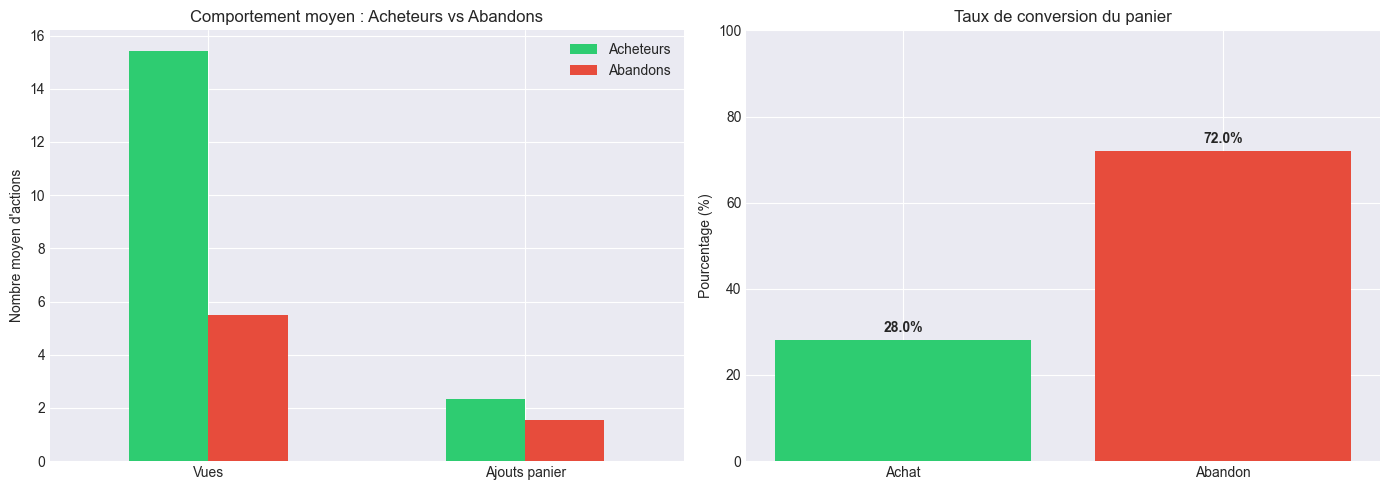


✅ Graphique sauvegardé !


In [3]:
# Analyse des abandons de panier
print("=" * 60)
print("📌 ANALYSE DES ABANDONS DE PANIER")
print("=" * 60)

# Utilisateurs qui ont ajouté au panier
users_with_cart = user_behavior[user_behavior['addtocart'] > 0]
users_purchased = user_behavior[user_behavior['purchases'] > 0]
users_abandoned = user_behavior[(user_behavior['addtocart'] > 0) & 
                                 (user_behavior['purchases'] == 0)]

print(f"\n📊 Statistiques panier :")
print(f"  Utilisateurs avec panier : {len(users_with_cart):,}")
print(f"  Utilisateurs ayant acheté : {len(users_purchased):,}")
print(f"  Utilisateurs panier abandonné : {len(users_abandoned):,}")

abandon_rate = (len(users_abandoned) / len(users_with_cart)) * 100
print(f"\n⚠️  Taux d'abandon de panier : {abandon_rate:.2f}%")

# Comparer le comportement
print("\n📈 Comparaison Acheteurs vs Abandons :")
print("\nAcheteurs (moyenne) :")
print(users_purchased[['views', 'addtocart', 'purchases']].mean())

print("\nAbandons (moyenne) :")
print(users_abandoned[['views', 'addtocart']].mean())

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparaison des moyennes
comparison = pd.DataFrame({
    'Acheteurs': users_purchased[['views', 'addtocart']].mean(),
    'Abandons': users_abandoned[['views', 'addtocart']].mean()
})

comparison.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Comportement moyen : Acheteurs vs Abandons')
axes[0].set_ylabel('Nombre moyen d\'actions')
axes[0].set_xticklabels(['Vues', 'Ajouts panier'], rotation=0)
axes[0].legend()

# Taux d'abandon
axes[1].bar(['Achat', 'Abandon'], 
           [100-abandon_rate, abandon_rate],
           color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Taux de conversion du panier')
axes[1].set_ylabel('Pourcentage (%)')
axes[1].set_ylim(0, 100)

for i, v in enumerate([100-abandon_rate, abandon_rate]):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/cart_abandonment.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé !")

📌 ANALYSE DES PRODUITS À OPTIMISER



📊 Produits populaires (≥50 vues) : 10,606

⚠️  Top 10 produits populaires avec FAIBLE conversion :
         views  addtocart  purchases  view_to_purchase_rate
itemid                                                     
187946  3410.0        2.0        0.0                    0.0
5411    2325.0        9.0        0.0                    0.0
370653  1854.0        0.0        0.0                    0.0
298009  1642.0        0.0        0.0                    0.0
96924   1633.0        0.0        0.0                    0.0
335975  1428.0        0.0        0.0                    0.0
151444  1230.0        0.0        0.0                    0.0
142466  1135.0        1.0        0.0                    0.0
434782  1069.0        0.0        0.0                    0.0
91755   1024.0        0.0        0.0                    0.0

✅ Top 10 produits populaires avec BONNE conversion :
         views  addtocart  purchases  view_to_purchase_rate
itemid                                                     
119736

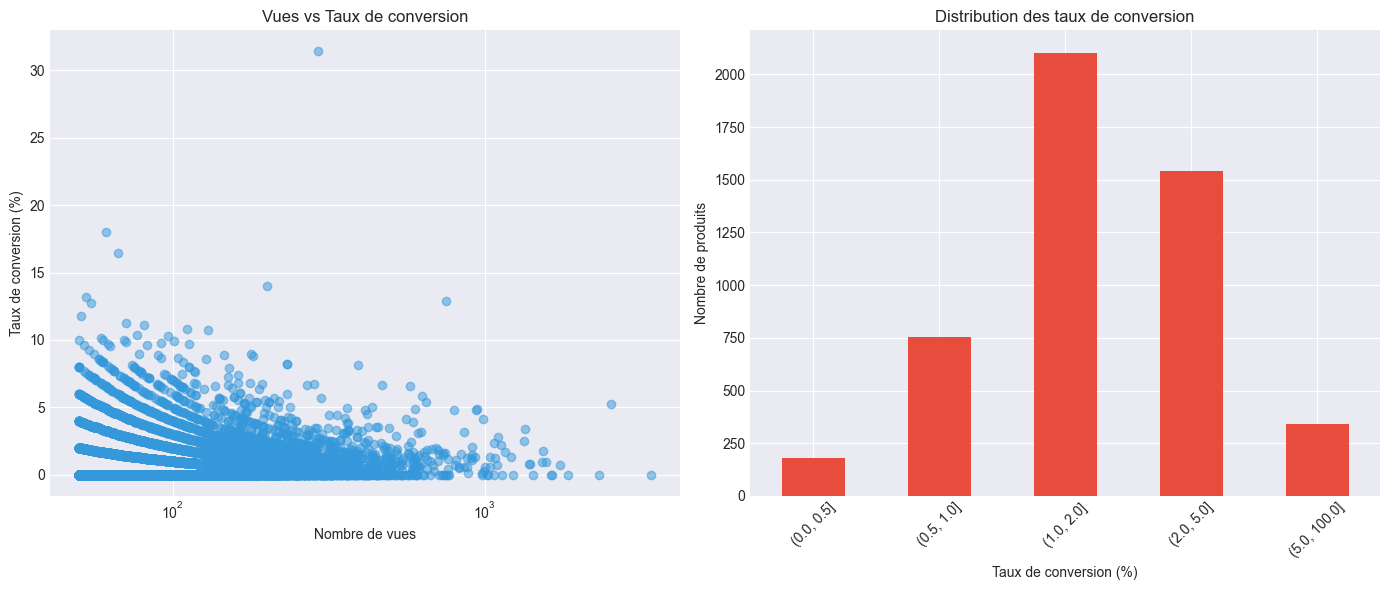


✅ Graphique sauvegardé !


In [4]:
# Analyse des produits à optimiser
print("=" * 60)
print("📌 ANALYSE DES PRODUITS À OPTIMISER")
print("=" * 60)

# Comportement par produit
product_stats = events.groupby('itemid').agg({
    'event': 'count',
    'visitorid': 'nunique'
}).rename(columns={'event': 'total_events', 'visitorid': 'unique_visitors'})

# Compter les événements par type
product_views = events[events['event'] == 'view'].groupby('itemid').size()
product_addtocart = events[events['event'] == 'addtocart'].groupby('itemid').size()
product_purchases = events[events['event'] == 'transaction'].groupby('itemid').size()

product_stats['views'] = product_views
product_stats['addtocart'] = product_addtocart.fillna(0)
product_stats['purchases'] = product_purchases.fillna(0)
product_stats = product_stats.fillna(0)

# Calculer les taux de conversion
product_stats['view_to_cart_rate'] = (product_stats['addtocart'] / product_stats['views'] * 100).fillna(0)
product_stats['cart_to_purchase_rate'] = (product_stats['purchases'] / product_stats['addtocart'] * 100).fillna(0)
product_stats['view_to_purchase_rate'] = (product_stats['purchases'] / product_stats['views'] * 100).fillna(0)

# Filtrer les produits avec au moins 50 vues
popular_products = product_stats[product_stats['views'] >= 50].copy()

print(f"\n📊 Produits populaires (≥50 vues) : {len(popular_products):,}")

# Top produits avec faible conversion (opportunités d'optimisation)
print("\n⚠️  Top 10 produits populaires avec FAIBLE conversion :")
low_conversion = popular_products.nlargest(100, 'views').nsmallest(10, 'view_to_purchase_rate')
print(low_conversion[['views', 'addtocart', 'purchases', 'view_to_purchase_rate']].round(2))

# Top produits avec bonne conversion (benchmarks)
print("\n✅ Top 10 produits populaires avec BONNE conversion :")
high_conversion = popular_products.nlargest(100, 'views').nlargest(10, 'view_to_purchase_rate')
print(high_conversion[['views', 'addtocart', 'purchases', 'view_to_purchase_rate']].round(2))

# Visualisation
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(popular_products['views'], popular_products['view_to_purchase_rate'], 
           alpha=0.5, c='#3498db')
plt.xlabel('Nombre de vues')
plt.ylabel('Taux de conversion (%)')
plt.title('Vues vs Taux de conversion')
plt.xscale('log')

plt.subplot(1, 2, 2)
conversion_bins = [0, 0.5, 1, 2, 5, 100]
popular_products['conversion_category'] = pd.cut(popular_products['view_to_purchase_rate'], 
                                                  bins=conversion_bins)
popular_products['conversion_category'].value_counts().sort_index().plot(kind='bar', color='#e74c3c')
plt.title('Distribution des taux de conversion')
plt.xlabel('Taux de conversion (%)')
plt.ylabel('Nombre de produits')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/product_conversion_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé !")

In [5]:
# Résumé des opportunités
print("=" * 60)
print("📌 OPPORTUNITÉS D'OPTIMISATION IDENTIFIÉES")
print("=" * 60)

opportunities = {
    '1. Abandon de panier': {
        'taux_actuel': '71.96%',
        'objectif': '60%',
        'action': 'Simplifier le checkout, ajouter urgence/réassurance'
    },
    '2. Conversion globale': {
        'taux_actuel': '0.84%',
        'objectif': '1.5%',
        'action': 'Améliorer pages produits, recommandations'
    },
    '3. Engagement visiteurs': {
        'taux_actuel': '97.2% visiteurs simples',
        'objectif': '90%',
        'action': 'Pop-ups, offres personnalisées'
    }
}

for i, (key, value) in enumerate(opportunities.items(), 1):
    print(f"\n{key}")
    print(f"  📊 État actuel : {value['taux_actuel']}")
    print(f"  🎯 Objectif    : {value['objectif']}")
    print(f"  💡 Action      : {value['action']}")

# Sauvegarder le résumé
summary_data = {
    'metric': ['Taux abandon panier', 'Conversion globale', 'Visiteurs engagés'],
    'current': [71.96, 0.84, 2.8],
    'target': [60, 1.5, 10],
    'gap': [11.96, 0.66, 7.2]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../data/processed/optimization_opportunities.csv', index=False)
print("\n✅ Opportunités sauvegardées dans optimization_opportunities.csv")

📌 OPPORTUNITÉS D'OPTIMISATION IDENTIFIÉES

1. Abandon de panier
  📊 État actuel : 71.96%
  🎯 Objectif    : 60%
  💡 Action      : Simplifier le checkout, ajouter urgence/réassurance

2. Conversion globale
  📊 État actuel : 0.84%
  🎯 Objectif    : 1.5%
  💡 Action      : Améliorer pages produits, recommandations

3. Engagement visiteurs
  📊 État actuel : 97.2% visiteurs simples
  🎯 Objectif    : 90%
  💡 Action      : Pop-ups, offres personnalisées

✅ Opportunités sauvegardées dans optimization_opportunities.csv
